In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e10/train.csv',index_col = 0)
test_df = pd.read_csv('/kaggle/input/playground-series-s3e10/test.csv', index_col = 0)

In [3]:
target = train_df.pop('Class')
train_features = train_df.copy()
test_features = test_df.copy()

In [4]:
train_features.describe()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve
count,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000
mean,111.248300,46.713535,0.503498,1.886385,11.962921,26.190678,8.037488,93.881076
std,24.906474,6.102941,1.127093,6.515466,26.719946,20.041937,3.840980,79.962110
min,6.054688,24.783273,-1.730782,-1.791886,0.213211,7.370432,-2.597872,-1.976976
25%,104.546875,43.443390,0.049761,-0.188956,2.090301,14.955405,6.742911,49.409136
50%,116.664062,47.478932,0.186498,0.091720,2.808528,18.164924,8.442883,83.421375
75%,126.296875,50.862718,0.395620,0.691613,4.122910,24.732218,10.003237,122.093290
max,189.367188,93.602933,7.879628,65.385974,217.371238,109.890785,34.539844,1191.000837


In [5]:
test_features.describe()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve
count,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000
mean,111.328650,46.729918,0.494829,1.833997,11.857477,26.075380,8.048395,94.034477
std,24.682112,6.088317,1.111206,6.401282,26.610344,19.929691,3.826233,79.905613
min,5.812500,24.772042,-1.788449,-1.791886,0.213211,7.448817,-2.556795,-1.976976
25%,104.585938,43.502110,0.050069,-0.190423,2.088629,14.954451,6.755894,49.704203
50%,116.554688,47.465944,0.185460,0.090628,2.803512,18.164951,8.444376,83.322761
75%,126.195312,50.854073,0.394856,0.692126,4.099498,24.547813,9.973464,122.093290
max,192.617188,91.808628,8.069522,64.117478,223.392141,110.544845,31.471559,1072.793069


In [6]:
train_df.duplicated().sum(),test_df.duplicated().sum()

(0, 0)

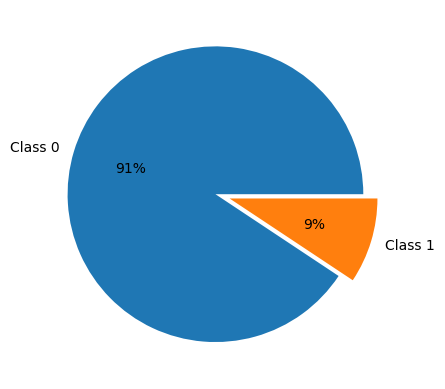

In [7]:
tg_percent = target.value_counts(True)
explode = [0,0.1]
plt.pie(tg_percent,labels = ['Class 0','Class 1'],explode = explode,autopct='%.0f%%')
plt.show()

# EDA

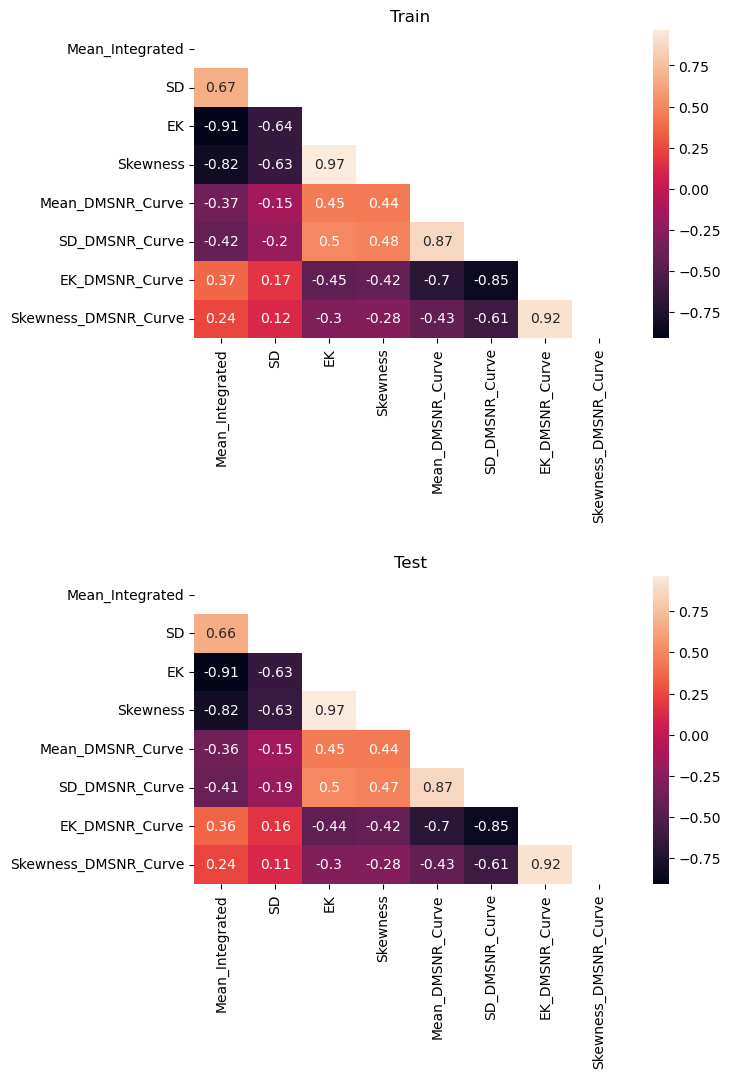

In [8]:
fig, ax = plt.subplots(2,figsize = (10,13))
fig.tight_layout(pad = 15.0)
labels = ['Train','Test']
for i, corr in enumerate([train_features.corr(),test_features.corr()]):
    mask = np.triu(corr)
    sns.heatmap(corr,annot = True,mask = mask, ax = ax[i])
    ax[i].set_title(labels[i])

# Features importances

In [9]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_features,target, test_size = 0.2)
model = XGBClassifier()
model.fit(x_train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

<AxesSubplot:>

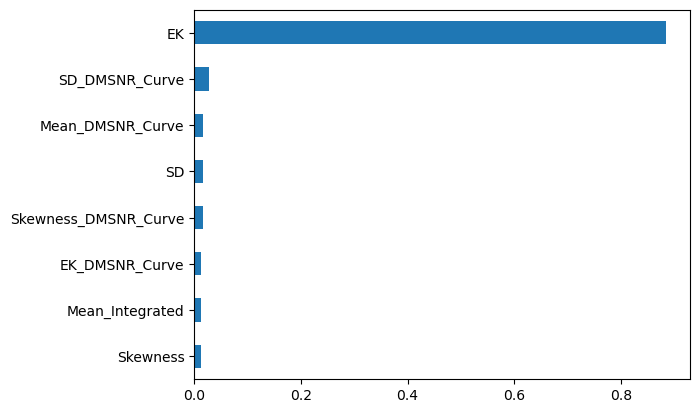

In [10]:
fi = model.feature_importances_
fi = pd.Series(fi, index = train_features.columns).sort_values(ascending = True)
fi.plot(kind = 'barh')

In [11]:
predict = model.predict(x_test)

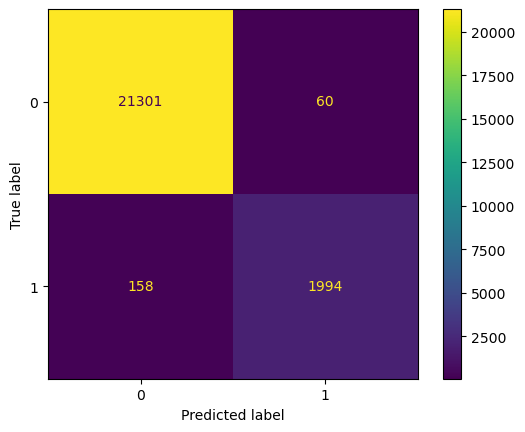

In [12]:
cfm = metrics.confusion_matrix(y_test,predict)
cfm = metrics.ConfusionMatrixDisplay(cfm)
cfm.plot()

# Hyperparameters Tuning

In [13]:
import optuna

## Searching the best parameter with optuna
d_train = xgb.DMatrix(x_train,y_train)
d_test = xgb.DMatrix(x_test,y_test)

def objective(trial):
    params = {
        'verbosity':0,
        'n_estimators': trial.suggest_int("n_estimators", 50, 1500),
        'learning_rate': trial.suggest_float('learning_rate',1e-8,1.0),
        'max_depth':trial.suggest_int('max_depth', 3, 12),
        'gamma':trial.suggest_float('gamma',0,8),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),
        'colsample_bytree':trial.suggest_float('colsample_bytree',1e-5,1.0),
        'min_child_weight':trial.suggest_int('trial.suggest_int',0,50),
        'booster':trial.suggest_categorical("booster", ["dart", "gbtree"]),
        'sampling_method': trial.suggest_categorical('sampling_method',['uniform','gradient_based']),
        'reg_alpha': trial.suggest_float("reg_alpha", 0, 1),
        'reg_lambda': trial.suggest_float("reg_lambda", 0, 1),
        'tree_method': 'gpu_hist',
    }
    
    sch_prm = xgb.train(params, d_train,
                        evals = [(d_test, 'valid')], 
                        early_stopping_rounds=50, verbose_eval=False
                       )
    
    return sch_prm.best_score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials = 30)

[I 2023-03-20 09:37:40,158] A new study created in memory with name: no-name-cc6e68b1-9c1f-4130-b093-9fa0ad1a221b
[I 2023-03-20 09:37:41,072] Trial 0 finished with value: 0.134167205983376 and parameters: {'n_estimators': 1323, 'learning_rate': 0.33026507838054403, 'max_depth': 11, 'gamma': 4.9141994418323485, 'lambda': 0.35402690309964086, 'alpha': 0.3458893362039852, 'colsample_bytree': 0.07692976813439416, 'trial.suggest_int': 44, 'booster': 'gbtree', 'sampling_method': 'gradient_based', 'reg_alpha': 0.6899918743804918, 'reg_lambda': 0.3306736206062725}. Best is trial 0 with value: 0.134167205983376.
[I 2023-03-20 09:37:41,116] Trial 1 finished with value: 0.1258716945168873 and parameters: {'n_estimators': 1442, 'learning_rate': 0.7149290388408973, 'max_depth': 3, 'gamma': 3.193211684093974, 'lambda': 0.09519978478867952, 'alpha': 0.03530200070883725, 'colsample_bytree': 0.226149067974781, 'trial.suggest_int': 32, 'booster': 'gbtree', 'sampling_method': 'gradient_based', 'reg_alpha

In [14]:
best_params = study.best_trial.params
best_params

{'n_estimators': 722,
 'learning_rate': 0.4395947577373885,
 'max_depth': 5,
 'gamma': 1.4205889734709798,
 'lambda': 0.9889766355014197,
 'alpha': 0.5043020579318176,
 'colsample_bytree': 0.886824837253385,
 'trial.suggest_int': 33,
 'booster': 'gbtree',
 'sampling_method': 'gradient_based',
 'reg_alpha': 0.8130230020055749,
 'reg_lambda': 0.8590265817469283}

In [15]:

num_folds = 10
loglosses = []
final_preds = np.zeros(len(test_df))
kf = StratifiedKFold(n_splits=num_folds, shuffle = True, random_state = 42)
for fold, (trn_idx, val_idx) in enumerate(kf.split(train_features, target)):
    print('-'*20, 'Fold:', fold, '-'*20)
    X_train, X_test = train_features.iloc[trn_idx], train_features.iloc[val_idx]
    y_train, y_test = target.iloc[trn_idx], target.iloc[val_idx]
    
    model =  XGBClassifier(**best_params,
                           early_stopping_rounds = 50, tree_method='gpu_hist')
    model.fit(X_train, y_train,
            eval_set = [(X_test, y_test)],
            verbose = 1000)
    preds = model.predict_proba(X_test)[:, 1]
    logloss = metrics.log_loss(y_test, preds)
    loglosses.append(logloss)
    print(f'Logloss: {logloss}')
    
    preds = model.predict_proba(test_df)[:,1]
    final_preds += preds / num_folds
    

print(f'The average of all log losses: {np.mean(loglosses)}')

-------------------- Fold: 0 --------------------
[0]	validation_0-logloss:0.35691
[92]	validation_0-logloss:0.02596
Logloss: 0.025957408531828267
-------------------- Fold: 1 --------------------
[0]	validation_0-logloss:0.35810
[72]	validation_0-logloss:0.03357
Logloss: 0.03350066506770706
-------------------- Fold: 2 --------------------
[0]	validation_0-logloss:0.35819
[72]	validation_0-logloss:0.03115
Logloss: 0.031026622892049417
-------------------- Fold: 3 --------------------
[0]	validation_0-logloss:0.35865
[86]	validation_0-logloss:0.03235
Logloss: 0.0323515585208054
-------------------- Fold: 4 --------------------
[0]	validation_0-logloss:0.35823
[69]	validation_0-logloss:0.03195
Logloss: 0.031808677580478846
-------------------- Fold: 5 --------------------
[0]	validation_0-logloss:0.35841
[68]	validation_0-logloss:0.03129
Logloss: 0.031252112944588524
-------------------- Fold: 6 --------------------
[0]	validation_0-logloss:0.35902
[69]	validation_0-logloss:0.03480
Logl

In [16]:
submission = pd.read_csv('/kaggle/input/playground-series-s3e10/sample_submission.csv')
sub_preds = np.vstack(final_preds)
sub_preds.shape

(78377, 1)

In [17]:
submission['Class'] = sub_preds
submission.to_csv("submission.csv", index=False)